In [50]:
%matplotlib inline

import math
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
import plot

In [51]:
def fmt_money(number):
    return "${:,.0f}".format(number)

In [52]:
def run_pmt(market, pmt_rate):
    portfolio = 1_000_000
    age = 65
    max_age = 100
    df = pandas.DataFrame(index=range(age, max_age), columns=['withdrawal', 'portfolio'])
    for i in range(age, max_age):
        withdraw = -numpy.pmt(pmt_rate, max_age-i, portfolio, 0, 1)
        portfolio -= withdraw
        portfolio *= (1 + market)
        df.loc[i] = [int(withdraw), int(portfolio)]
    return df

In [53]:
pmt_df = run_pmt(0.03, 0.04)
pmt_df.head()

,withdrawal,portfolio
65,51516,976937
66,51021,953694
67,50530,930258
68,50044,906619
69,49563,882767


In [54]:
def run_smile(target):
    spend = target
    s = pandas.Series(index=range(66,100), dtype=int)
    for age in range(66, 100):
        d = (0.00008 * age * age) - (0.0125 * age) - (0.0066 * math.log(target)) + 0.546
        spend *= (1 + d)
        s.loc[age] = int(spend)
    return s

In [55]:
smile_s = run_smile(pmt_df.iloc[0]['withdrawal'])
smile_s.head()

66    51406
67    51201
68    50910
69    50542
70    50107
dtype: int64

In [56]:
def rmse(s1, s2):
    return numpy.sqrt(numpy.mean((s1-s2)**2))

In [57]:
rmse(pmt_df['withdrawal'][1:26], smile_s[:26])

696.8561401035367

In [111]:
def harness():
    df = pandas.DataFrame(columns=['market', 'pmtrate', 'rmse'])
    for returns in numpy.arange(0.01, 0.10+0.001, 0.001):
        for pmt_rate in numpy.arange(0.01, 0.10+0.001, 0.001):
            pmt_df = run_pmt(returns, pmt_rate)
            iwd = pmt_df.iloc[0]['withdrawal']
            smile_s = run_smile(iwd)
            errors = rmse(pmt_df['withdrawal'], smile_s)
            df = df.append({'market': returns, 'pmtrate': pmt_rate, 'rmse': errors}, ignore_index=True)
    return df

In [112]:
error_df = harness()
error_df.head()

,market,pmtrate,rmse
0,0.01,0.010,3655.058199
1,0.01,0.011,3145.900816
2,0.01,0.012,2652.603588
3,0.01,0.013,2184.852216
4,0.01,0.014,1766.614018


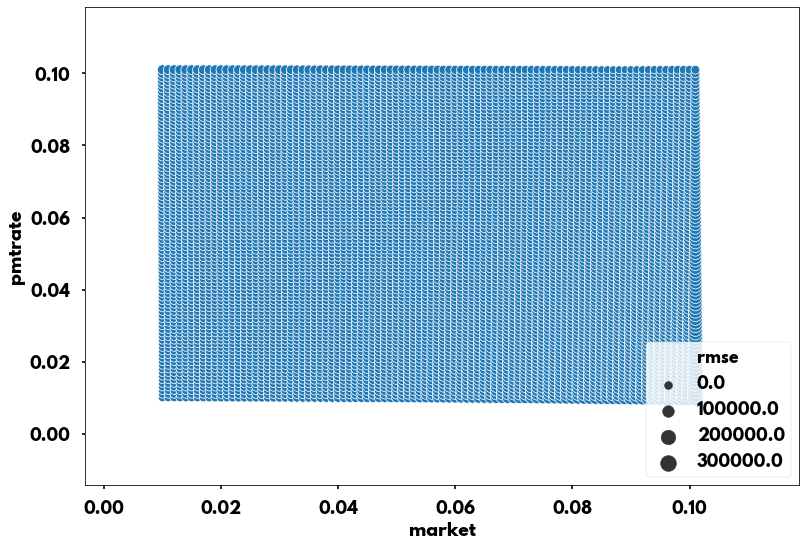

In [113]:
#seaborn.scatterplot(data=error_df, x='market', y='pmtrate', size='rmse')

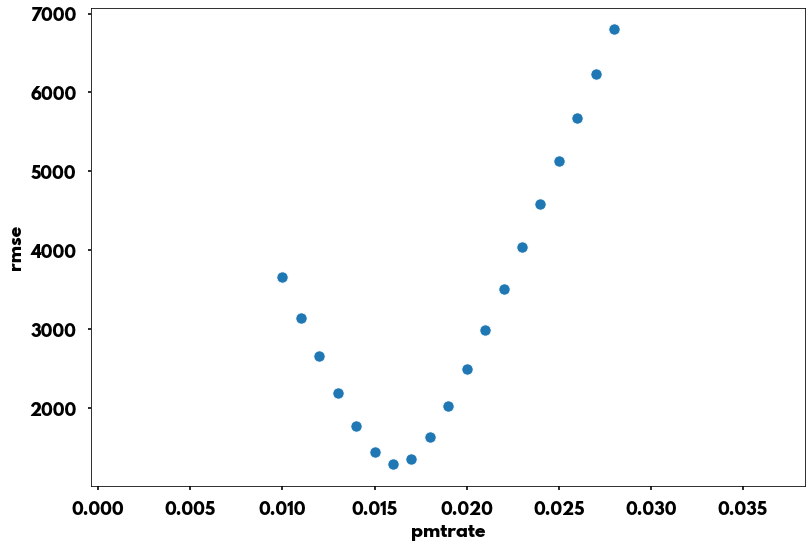

In [114]:
#seaborn.scatterplot(data=error_df[0:19], x='pmtrate', y='rmse')

In [127]:
error_df[0:91]

,market,pmtrate,rmse
0,0.01,0.010,3655.058199
1,0.01,0.011,3145.900816
2,0.01,0.012,2652.603588
3,0.01,0.013,2184.852216
4,0.01,0.014,1766.614018
...,...,...,...
86,0.01,0.096,46547.405545
87,0.01,0.097,47129.065011
88,0.01,0.098,47709.830836
89,0.01,0.099,48290.399117


8464 93 91


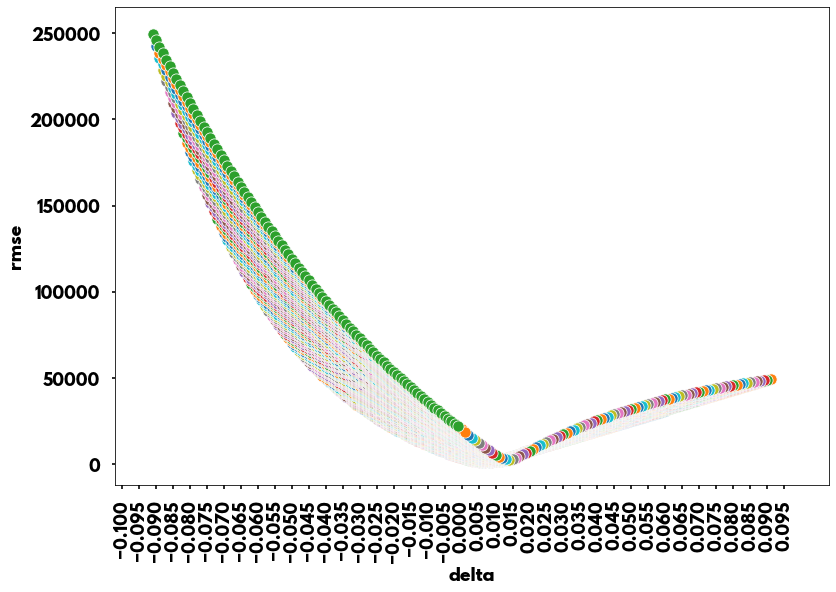

In [128]:
slice_size = 91
n_slices = int(len(error_df) / slice_size)
print(len(error_df), n_slices, slice_size)
for i in range(n_slices):
    start = i * slice_size
    end = i * slice_size + slice_size
    slice_df = error_df[start:end]
    delta = slice_df['pmtrate'] - slice_df['market']
    plot_df = pandas.DataFrame({'delta': delta, 'rmse': slice_df['rmse']})
    sp = seaborn.scatterplot(data=plot_df, x='delta', y='rmse')
    mkt_rate = slice_df.iloc[0]['market']
    plt.xticks(numpy.arange(-0.100, +0.100, 0.005), rotation='vertical')
#    plt.title(f'Market returns: {mkt_rate*100}%')

In [116]:
series = pandas.Series(index=range(40_000, 101_000, 5_000))
for t in range(40_000, 101_000, 5_000):
    s = run_smile(t)
    contingency = (t - s[0:20]).sum()
    series.loc[t] = contingency

Text(0.5, 1.0, 'Contigency at age 85')

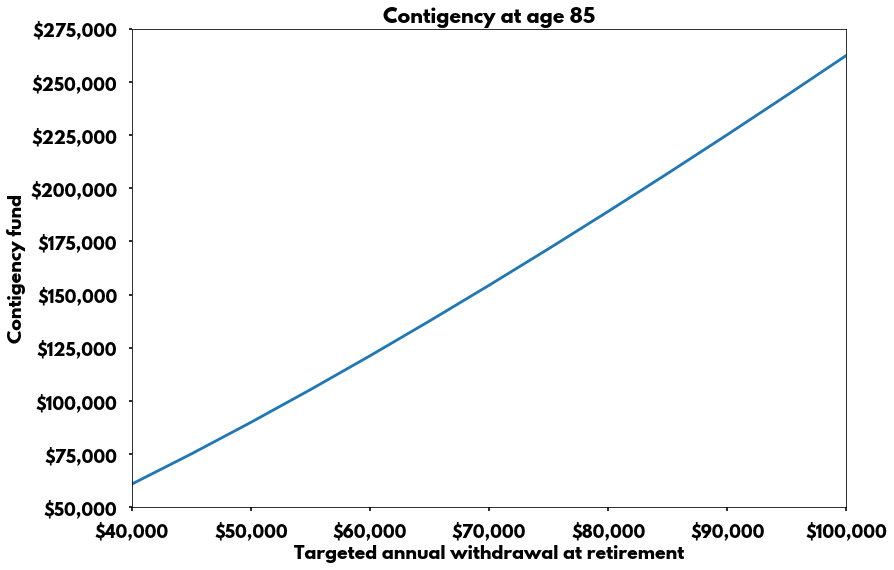

In [117]:
series.plot()
plt.xlabel('Targeted annual withdrawal at retirement')
plt.ylabel('Contigency fund')
xticks = plt.xticks()
plt.xticks(xticks[0], [fmt_money(x) for x in xticks[0]])
yticks = plt.yticks()
plt.yticks(yticks[0], [fmt_money(y) for y in yticks[0]])
plt.title('Contigency at age 85')

In [118]:
series

40000      60944.0
45000      75143.0
50000      89976.0
55000     105370.0
60000     121273.0
65000     137639.0
70000     154426.0
75000     171609.0
80000     189150.0
85000     207029.0
90000     225227.0
95000     243726.0
100000    262504.0
dtype: float64

([<matplotlib.axis.XTick at 0x7fd921248518>,
 <a list of 7 Text xticklabel objects>)

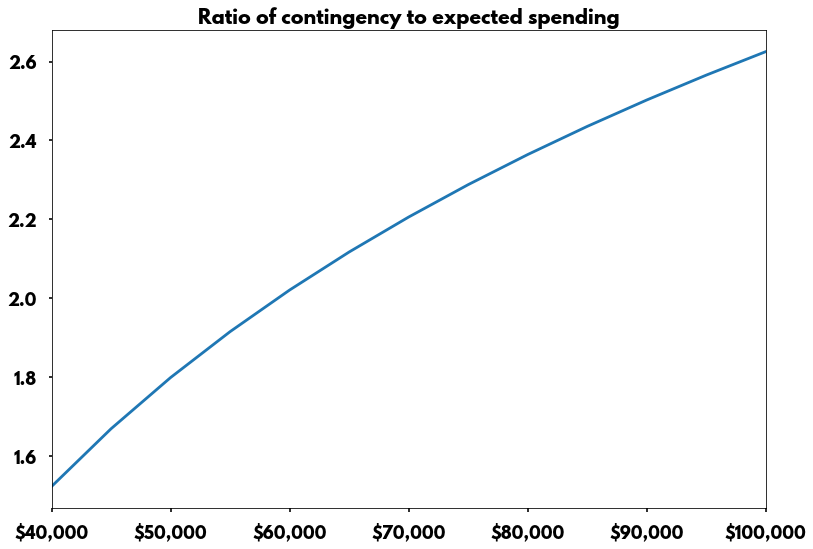

In [119]:
(series / series.index).plot()
plt.title('Ratio of contingency to expected spending')
xticks = plt.xticks()
plt.xticks(xticks[0], [fmt_money(x) for x in xticks[0]])

In [120]:
len(error_df)

8464